# Machine Learning II
## Urban Sound Classification: Deep Learning Approaches for Audio Recognition
#### Work assembled by Aligga Goncigga, Francigga Niggalache, Alexigga Luskigga

### Table of contents <a name="contents"></a>
1. [Introduction](#introduction)
2. [Data Understanding](#data-understanding)
3. [Data Reading](#data-reading)
    - 3.1. [Feature Extraction](#feature-extraction)
5. [Classifiers](#classifiers)

   - 4.1. [Multilayer Perceptron (MLP)](#multilayer)
   - 4.2. [convolutional neural network (CNN)](#convolutional)
   
   
  

## Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

The objective of this project is to develop **deep learning classifiers** for urban sound data. In this assignment, we will implement two of the three classifiers provided by the professor, as outlined in the [[PDF]](./Project.pdf). 

The classifiers are:

• A classifier based on a multilayer perceptron (MLP)

• A classifier based on a convolutional neural network (CNN)

• A classifier based on a recurrent neural network (RNN)

And for each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation

## Data Understanding <a name="data-understanding"></a>
[[go back to the top]](#contents)


The dataset consists of 8,732 labeled sound excerpts, each lasting up to 4 seconds, categorized into 10 distinct classes:
- air_conditioner [0] 
- car_horn [1] 
- children_playing [2] 
- dog_bark [3] 
- drilling [4] 
- enginge_idling [5] 
- gun_shot [6] 
- jackhammer [7] 
- siren [8] 
- street_music [9] 

The sound classes in the UrbanSound and UrbanSound8K datasets are derived from the UrbanSound taxonomy, as presented on the https://urbansounddataset.weebly.com/taxonomy.html

Below is an image showcasing the taxonomy structure from the referenced site:

![Descrição da imagem](./taxonomy.png)

All audio excerpts are derived from field recordings uploaded to http://www.freesound.org/

The dataset comprises 8,732 urban sound audio files in WAV format. The sampling rate, bit depth, and number of channels correspond to those of the original files uploaded to Freesound, which may vary across different recordings.

In addition to the audio excerpts, a CSV file containing metadata for each excerpt is also included.

This is a short explanation of the csv:

| Name of the Column | Brief Explanation                                                                                       |
|--------------------|--------------------------------------------------------------------------------------------------------|
| slice_file_name    | The name of the audio file, formatted as [fsID]-[classID]-[occurrenceID]-[sliceID].wav.              |
| fsID               | The Freesound ID of the recording from which this excerpt (slice) is taken.                           |
| start              | The start time of the slice in the original Freesound recording.                                      |
| end                | The end time of the slice in the original Freesound recording.                                        |
| salience           | A subjective salience rating of the sound (1 = foreground, 2 = background).                           |
| fold               | The fold number (1-10) to which this file has been allocated.                                         |
| classID            | A numeric identifier of the sound class (0-9) as listed above.                                        |
| class              | The class name corresponding to the classID (e.g., air_conditioner, car_horn, etc.).                 |
| [occurrenceID]     | A numeric identifier to distinguish different occurrences of the sound within the original recording. |
| [sliceID]          | A numeric identifier to distinguish different slices taken from the same occurrence.                 |


**To avoid common pitfalls**:
-  Don't reshuffle the data! Use the predefined 10 folds and perform 10-fold (not 5-fold) cross validation
-  Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores

## Data Reading <a name="data-reading"></a>
[[go back to the top]](#contents)


After carefully analyzing the three available classifiers, we decided to implement MLP and CNN for this project. Our decision was based on several important considerations, which we have outlined in detail in the following [[Notes]](./Notas.md).

Let's explore what we have and outline what we'll be working on in the coming days.



#### Imports

In [2]:
import pandas as pd
import librosa
import os
import numpy as np
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
path_csv = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/metadata/UrbanSound8K.csv'

df = pd.read_csv(path_csv)

print(df.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


##### Check if there's any missing values

In [10]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


##### Visualizing graphically

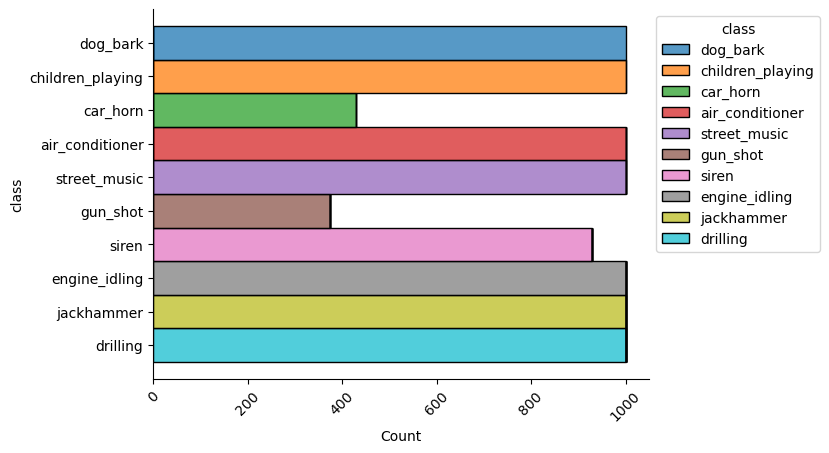

In [13]:
ax = sns.histplot(y='class',data = df, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45);
sns.despine()
plt.show()

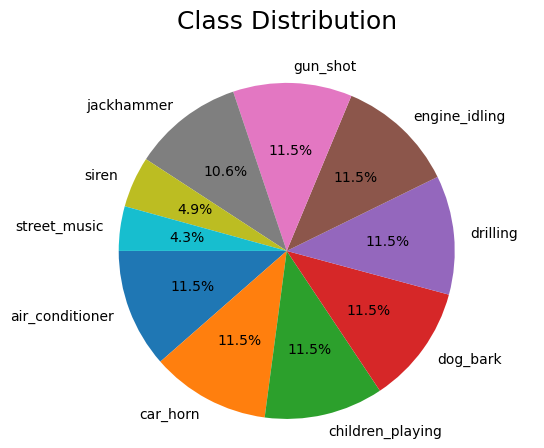

In [15]:
class_dict = df['class'].value_counts(normalize=True)
classes = list(np.unique(df['class']))
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(class_dict, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.savefig("distribution_class")
plt.show(block=False)

##### Accessing the audio data

In [9]:
# Path to the folder where the audio dubs are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Go through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Browse the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Upload audio using librosa
                audio, sample_rate = librosa.load(file_path)
                
                # Example: Process audio or extract features
                print(f"File: {file_name}, Sample Rate: {sample_rate}, Duration: {len(audio)/sample_rate:.2f}s")


File: 101415-3-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-8.wav, Sample Rate: 22050, Duration: 4.00s
File: 102106-3-0-0.wav, Sample Rate: 22050, Duration: 1.64s
File: 102305-6-0-0.wav, Sample Rate: 22050, Duration: 2.61s
File: 102842-3-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-5.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-6.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-4.wav, Sample Rate: 220

##### As observed, some audio clips have varying durations, such as 1.64, 2.61, and up to 4 seconds. To simplify the processing and ensure consistency, we will standardize all audio data to the same length. This allows for uniform input to our models, improving training efficiency and performance. How can we do that?

##### Well, there's four strategies:
- **Zeropadding:** Ideal for maintaining the integrity of short audios.
- **Audio Repetition:** Works well for rhythmic or repetitive sounds.
- **Discard Short Audios:** Simple and effective when you can afford to lose some data.
- **Interpolation:** Suitable if you want to maintain consistency in the timing of the audio, but can change the way it sounds.

We will choose Zeropadding.

##### Zeropadding:

In [27]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050  # sample rate

# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Check if the audio is shorter than the target duration
                if len(audio) < target_duration * sample_rate:
                    padding = int(target_duration * sample_rate) - len(audio)
                    audio_padded = np.pad(audio, (0, padding), mode='constant')
                else:
                    audio_padded = audio
                
                # Save the adjusted audio, replacing the original (or in a new directory)
                sf.write(file_path, audio_padded, sample_rate)
                print(f"File {file_name} processed with duration of {target_duration} seconds.")


Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold1...
File 101415-3-0-2.wav processed with duration of 4.0 seconds.
File 101415-3-0-3.wav processed with duration of 4.0 seconds.
File 101415-3-0-8.wav processed with duration of 4.0 seconds.
File 102106-3-0-0.wav processed with duration of 4.0 seconds.
File 102305-6-0-0.wav processed with duration of 4.0 seconds.
File 102842-3-0-1.wav processed with duration of 4.0 seconds.
File 102842-3-1-0.wav processed with duration of 4.0 seconds.
File 102842-3-1-5.wav processed with duration of 4.0 seconds.
File 102842-3-1-6.wav processed with duration of 4.0 seconds.
File 103074-7-0-0.wav processed with duration of 4.0 seconds.
File 103074-7-0-1.wav processed with duration of 4.0 seconds.
File 103074-7-0-2.wav processed with duration of 4.0 seconds.
File 103074-7-1-0.wav processed with duration of 4.0 seconds.
File 103074-7-1-1.wav processed with duration of 4.0 seconds.
File 103074-7-1-2.wav processed wit

##### Checking if there's still audios with duration different than 4 seconds

In [28]:
# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8725
Audio files with a duration different from 4 seconds:
36429-2-0-13.wav - Duration: 4.04 seconds
36429-2-0-14.wav - Duration: 4.04 seconds
36429-2-0-15.wav - Duration: 4.04 seconds
36429-2-0-18.wav - Duration: 4.04 seconds
36429-2-0-23.wav - Duration: 4.04 seconds
36429-2-0-6.wav - Duration: 4.04 seconds
36429-2-0-7.wav - Duration: 4.04 seconds


##### Okay, we still have files with more than 4 seconds. For that we have a strategy called Trimming.

In [35]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050  # sample rate

# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Check if the audio duration is greater than 4 seconds
                if len(audio) > target_duration * sample_rate:
                    # Trim audio to exactly 4 seconds
                    audio = audio[:int(target_duration * sample_rate)]
                    print(f"Trimming {file_name} to {target_duration} seconds.")
                    
                    # Save the trimmed audio, replacing the original file
                    sf.write(file_path, audio, sample_rate)



Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold1...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold2...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold3...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold4...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold5...
Trimming 19007-4-0-0.wav to 4.0 seconds.

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold6...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold7...

Processing files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold8...
Trimming 36429-2-0-13.wav to 4.0 seconds.
Trimming 36429-2-0-14.wav to 4.0 seconds.
Trimming 36429-2-0-15.wav to 4.0 seconds.
Trimming 36429-2-0-18.wav to 4.0 seconds.
Trimming 36429-

##### Let's see now if all the files have 4 seconds.

In [38]:
# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8732
All audio files are 4 seconds long.


##### Great! Now, let's begin the feature extraction.

## Feature Extraction <a name="feature-extraction"></a>
[[go back to the top]](#contents)

As described in [[Notes]](./Notas.md) and in [[PDF]](./Project.pdf), we will need to extract features, and for that we'll use **Mel-Frequency Cepstral Coefficients (MFCCs)** which are well known for their success in environmental sound classification.

We will create a csv to save those features. The provided code returns a 2D array where each row represents an MFCC and each column corresponds to a time frame calculates the mean of each MFCC across time, creating a fixed-size feature vector per audio clip. This step is optional but often used to simplify the features.

In [43]:
# Path to the folder where the audio files are located
base_path = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'

# Parameters for MFCC extraction
sample_rate = 22050  # Consistent sample rate for all files
n_mfcc = 13          # Number of MFCC features to extract
target_duration = 4.0  # Target duration for each audio clip in seconds

# List to store MFCC features and file names
mfcc_features = []
file_names = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(base_path, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        print(f"\nExtracting MFCCs from files in {fold_path}...")
        
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio with librosa
                audio, sr = librosa.load(file_path, sr=sample_rate)
                
                # Ensure audio length is consistent with target duration
                if len(audio) < target_duration * sample_rate:
                    padding = int(target_duration * sample_rate) - len(audio)
                    audio = np.pad(audio, (0, padding), mode='constant')
                else:
                    audio = audio[:int(target_duration * sample_rate)]
                
                # Extract MFCCs
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
                mfcc_mean = np.mean(mfcc, axis=1)  # Mean over time to get a fixed-size vector
                
                # Store MFCCs and file name
                mfcc_features.append(mfcc_mean)
                file_names.append(file_name)

# Convert MFCC features to DataFrame
df = pd.DataFrame(mfcc_features)
df.columns = [f'MFCC_{i+1}' for i in range(n_mfcc)]  # Name columns as MFCC_1, MFCC_2, etc.
df.insert(0, 'file_name', file_names)  # Insert file names as the first column

# Normalize MFCC features
scaler = MinMaxScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])  # Normalize all MFCC columns (excluding file_name)

# Save to CSV
df.to_csv('mfcc_features_normalized.csv', index=False)
print("MFCC features extracted, normalized, and saved to 'mfcc_features_normalized.csv'.")


Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold1...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold2...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold3...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold4...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold5...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold6...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold7...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold8...

Extracting MFCCs from files in C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio\fold9...

Extracting MFCCs from files

In [48]:
# Function to extract features from a given audio file
def extract_features(audio_file, target_duration=4, target_sr=44100):

    # Load audio and define target sample rate
    y, sr = librosa.load(audio_file, sr=target_sr)

    # Ensure audio length is the same as the target duration using zero padding
    target_length = int(target_sr * target_duration)
    y = librosa.util.fix_length(y, size=target_length)

    # Normalize amplitude
    y = librosa.util.normalize(y)

    # Define variables for some features
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # spectral feature list
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    melspectogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    rms = librosa.feature.rms(y=y)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    crossing_rate = librosa.feature.zero_crossing_rate(y)

    # rhythm feature list
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)

    # Create a dictionary to store the mean value of the features
    features = {
        'chroma_stft': np.mean(chroma_stft),
        'chroma_cqt': np.mean(chroma_cqt),
        'chroma_cens': np.mean(chroma_cens),
        'melspectogram': np.mean(melspectogram),
        'rms': np.mean(rms),
        'centroid': np.mean(centroid),
        'bandwidth': np.mean(bandwidth),
        'contrast': np.mean(contrast),
        'flatness': np.mean(flatness),
        'rolloff': np.mean(rolloff),
        'crossing_rate': np.mean(crossing_rate),
        'tempogram': np.mean(tempogram),
        'fourier_tempogram': np.mean(fourier_tempogram)
    }

    # Add the mean of each MFCC feature to the dictionary
    for i in range(1, 41):
        features[f'mcffs_{i}'] = np.mean(mfccs[i - 1])
    return features


# Function to iterate through each audio folder and extract features from each file
def process_data(base_dir):
    for folder in os.listdir(base_dir):
        label_list = []
        features_list = []
        fold_dir = os.path.join(base_dir, folder)
        if os.path.isdir(fold_dir):
            for filename in os.listdir(fold_dir):
                file_path = os.path.join(fold_dir, filename)
                if filename.endswith('.wav'):
                    label = filename
                    features = extract_features(file_path)
                    features_list.append(features)
                    label_list.append(label)

        # Create DataFrame for each folder
        df = pd.DataFrame(features_list)
        df['Label'] = label_list
        # Save DataFrame as a CSV file
        df.to_csv('urbansounds_features' + folder + '.csv', index=False)
        # Display the DataFrame
        print(df.head())


def main():
    base_dir = 'C:/Users/aleja/OneDrive/Documentos/GitHub/AC-II/UrbanSound8K/audio'
    process_data(base_dir)


if __name__ == '__main__':
    main()

Empty DataFrame
Columns: [Label]
Index: []


C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.494283    0.559240     0.266609       3.462754  0.068631  1258.207615   
1     0.422105    0.562016     0.271383       3.130538  0.076677  1077.123550   
2     0.575468    0.607640     0.276090       2.266523  0.044331  1451.517441   
3     0.176781    0.529516     0.258692       1.491809  0.043291   971.924074   
4     0.414716    0.594937     0.266916       0.806771  0.035645  1015.464031   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1924.493656  20.915848  0.000031  2423.764861  ... -2.995337 -0.023960   
1  1650.668573  22.700130  0.000027  1814.468835  ... -5.310628 -1.302393   
2  2119.632590  18.997313  0.000058  2812.548404  ... -1.287394  1.236547   
3   955.464797  18.182232  0.582628  1823.206946  ... -0.359004  0.831756   
4  1454.226381  15.334085  0.345015  2011.700493  ... -0.779017  1.142003   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.066603    0.538408     0.259439       1.474878  0.036557   456.927729   
1     0.139189    0.584360     0.268159       2.017438  0.054859   726.037563   
2     0.040296    0.547284     0.258507       0.472292  0.020169   316.575820   
3     0.214074    0.598533     0.265274       2.051071  0.073691  1075.429274   
4     0.171543    0.565704     0.262206       3.386163  0.083622  1553.581487   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0   486.788961  12.496568  0.831885   993.086362  ... -1.528522  0.171344   
1   726.908800  13.568181  0.730458  1448.404382  ... -2.529804  0.619243   
2   271.345325  12.142186  0.892763   569.475204  ... -0.708788 -0.197704   
3  1044.425100  13.062040  0.588407  2132.161600  ... -3.925354  1.657697   
4  1294.767569  22.204016  0.527541  3235.722656  ... -2.362110  0.092519   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.411286    0.599462     0.274633       1.617276  0.062852  2150.007321   
1     0.392896    0.587730     0.272814       1.739756  0.062819  2105.097491   
2     0.410723    0.596081     0.276617       1.731786  0.058384  2106.061446   
3     0.392875    0.556554     0.268771       2.690495  0.072673  2025.631507   
4     0.108786    0.503260     0.249842       0.700118  0.021251   548.447956   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1737.106250  22.039907  0.000072  3474.273098  ... -0.470481  1.253036   
1  1605.402151  21.575430  0.000011  3214.688774  ...  0.693225  0.365737   
2  1631.335112  21.355995  0.000013  3275.481063  ...  2.370122 -1.293786   
3  1522.821684  21.637243  0.000035  3079.997028  ...  3.011242 -0.051725   
4   483.565960  17.984797  0.791307   986.532779  ... -0.496110  0.500314   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.418448    0.612386     0.278292       1.591015  0.073621  2395.941215   
1     0.506560    0.669599     0.281829       4.019243  0.163994  2664.309567   
2     0.571281    0.647358     0.278443       4.963150  0.196939  2387.519227   
3     0.603950    0.633610     0.276199       5.552674  0.203217  2263.202689   
4     0.608023    0.649571     0.278151       5.340950  0.199425  2271.631815   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2216.847177  21.264809  0.000024  4348.021824  ... -0.545829  2.606326   
1  1958.375485  21.963711  0.000605  4226.686906  ... -6.241166  4.327957   
2  1793.727331  22.132807  0.000043  3808.318614  ... -4.774907  4.636101   
3  1769.663008  22.032463  0.000010  3659.521060  ... -5.436294  6.268219   
4  1785.932469  21.640399  0.000034  3651.719175  ... -4.528340  7.720985   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.355094    0.628593     0.274369       2.446153  0.090505  1841.207683   
1     0.244764    0.483293     0.260922       7.894195  0.185982  2514.520297   
2     0.412832    0.616808     0.274673       2.135502  0.115019  2947.727335   
3     0.264722    0.481660     0.264932       3.353574  0.135027  2877.416067   
4     0.556929    0.549660     0.269304       3.291662  0.144328  2392.909025   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1744.814710  20.322628  0.220293  3300.322266  ... -2.372887  1.787201   
1  2375.854198  23.000901  0.000009  5060.677225  ... -5.204763  0.111176   
2  2540.544631  21.538295  0.000029  5741.313689  ... -3.141013  5.237492   
3  2586.929911  22.933707  0.000011  5785.253906  ... -9.722857  0.254809   
4  2161.179496  21.330172  0.000014  4674.639946  ... -2.897305  5.928905   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.035959    0.475654     0.249209       0.303597  0.009348   236.217922   
1     0.506755    0.702075     0.278764       2.667348  0.136734  2108.375247   
2     0.565834    0.668502     0.276892       5.689481  0.185926  1822.130380   
3     0.479199    0.610088     0.275963       3.500393  0.140281  2238.451737   
4     0.555109    0.441960     0.264775       6.997726  0.215511  1971.349795   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0   192.841007  13.435288  0.913055   361.570567  ... -0.502542  0.338952   
1  1957.569741  21.493484  0.000039  3968.600543  ... -5.211990  2.956032   
2  1932.287312  20.870084  0.000032  3665.138417  ... -3.039133  1.835087   
3  2230.116161  22.185409  0.000002  4416.428753  ... -5.694881  2.391070   
4  1930.441701  20.751058  0.000009  3887.086447  ... -3.715510  4.718604   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.538096    0.702256     0.284575       0.777187  0.064652  3576.867730   
1     0.521984    0.645030     0.280312       3.994538  0.153904  3285.808258   
2     0.521957    0.686422     0.283016       1.254498  0.088118  3190.304580   
3     0.590493    0.759246     0.285024       1.654414  0.100049  2908.475515   
4     0.497376    0.718185     0.283367       8.050267  0.214217  2518.362627   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2571.227596  20.847347  0.000308  6646.332371  ... -4.813118  6.120197   
1  2477.727294  21.593522  0.000052  6120.547724  ... -2.960623  7.459517   
2  2345.411920  21.171399  0.000010  5672.095363  ... -4.694443  5.908859   
3  2792.008245  20.099395  0.000024  6424.384341  ... -4.353232  5.424568   
4  2634.858557  20.288473  0.000019  5646.255520  ... -4.370856  5.107643   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.473279    0.423700     0.252005       7.094579  0.183298  1335.245505   
1     0.509057    0.417533     0.249702       8.105205  0.195949  1325.707391   
2     0.489355    0.424997     0.249331       6.818939  0.180858  1420.881168   
3     0.492828    0.447101     0.251485       7.167441  0.182778  1320.470780   
4     0.507439    0.492269     0.261741       1.277653  0.076990  1292.931888   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1877.474255  22.214009  0.000013  2431.816406  ... -3.722197  3.461062   
1  1874.991192  22.061054  0.000009  2419.895126  ... -3.396806  4.197931   
2  1934.880429  22.734150  0.000002  2727.164572  ... -3.823392  4.048650   
3  1829.305698  22.566352  0.000002  2500.785071  ... -3.563521  2.698436   
4  1844.732264  21.276968  0.000004  2342.625255  ... -5.483507  1.163922   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.212593    0.521886     0.262804       2.123175  0.033413   947.670308   
1     0.071946    0.503162     0.254834       1.386629  0.021169   340.598745   
2     0.044379    0.548775     0.259438       0.684735  0.010952   250.229948   
3     0.453460    0.617095     0.278163       2.503996  0.118893  2323.424294   
4     0.464938    0.584814     0.276180       3.281008  0.135486  2420.828955   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  1202.746574  19.350788  0.362345  1577.478770  ... -1.463641 -1.712757   
1   417.279444  21.612369  0.750771   524.661175  ... -0.653061 -0.889936   
2   266.873437  18.598528  0.881172   419.429348  ... -0.892459 -0.432758   
3  2010.222651  21.299679  0.000012  4409.438264  ... -2.909724  5.448082   
4  2147.038154  21.191897  0.000026  4663.966967  ... -2.853166  6.443117   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=345
  warnings.warn(
C:\Users\aleja\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.508138    0.666251     0.278819       0.786477  0.100348  4900.920913   
1     0.437211    0.612937     0.277053       0.740018  0.096326  4285.206959   
2     0.477068    0.620618     0.276967       0.741614  0.097009  4693.149151   
3     0.518304    0.644791     0.276738       0.637078  0.088621  4906.108613   
4     0.534181    0.640025     0.276232       0.542453  0.078149  4466.607596   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  2953.028223  21.372229  0.000047  8526.212211  ... -2.680714  6.400740   
1  2903.339519  21.766786  0.000015  7824.729110  ... -2.015165  6.447560   
2  2945.841100  21.687075  0.000014  8363.371264  ... -2.508668  6.615347   
3  2972.385036  21.602222  0.000044  8578.765710  ... -2.986303  6.509528   
4  2973.506783  21.398837  0.000017  8123.073200  ... -2.350351  5.896286   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3